In [94]:
from datetime import timedelta

import data
import numpy as np
from main import initiate_models, run_models
import scipy.interpolate as inter

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

In [95]:
fname = "../results/patchsize.txt"
params, _ = data.get_params()
biom_data, *_ = data.get_data()

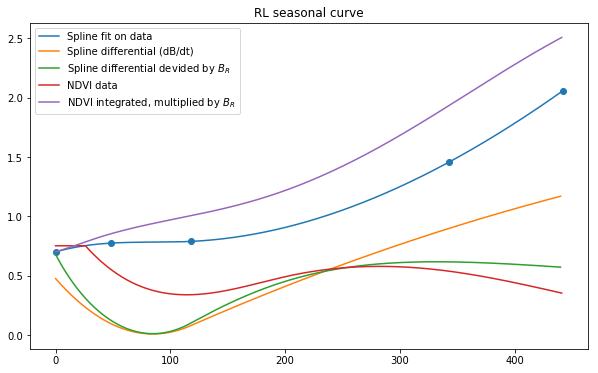

In [114]:
RL_data = [biom_data[key] for key in biom_data.keys() if key[-1] == 'R']
RL_cumulative = np.nanmean(np.vstack(RL_data), axis=0)

# Do a spline fit to data
dates = data.measurements
date_ax = [(date - dates[0]).days for date in dates]
RL_spline = inter.InterpolatedUnivariateSpline(date_ax, RL_cumulative)

days = range((dates[-1] - dates[0]).days)
cumm = RL_spline(days)
diff = np.diff(RL_spline(days)) / params['R_g']
seasonal_values = data.get_seasonality()
seasonal_ax = [seasonal_values[dates[0] + timedelta(i)] for i in days]
seasonal_ax = np.array(seasonal_ax)

seasonal_int = [RL_cumulative[0]]
for L_ext in seasonal_ax[:-1]:
    growth = L_ext * params['R_g'] * seasonal_int[-1]
    seasonal_int.append(seasonal_int[-1] + growth)

plt.scatter(date_ax, RL_cumulative)
plt.plot(days, cumm, label="Spline fit on data")
plt.plot(days[:-1], diff, label="Spline differential (dB/dt)")
plt.plot(days[:-1], diff/ (cumm[:-1]), label="Spline differential devided by $B_R$")
plt.plot(days, seasonal_ax, label="NDVI data")
plt.plot(days, seasonal_int, label="NDVI integrated, multiplied by $B_R$")
plt.title("RL seasonal curve")
plt.legend()
plt.savefig('../results/RL_seasonal.png')
plt.show()

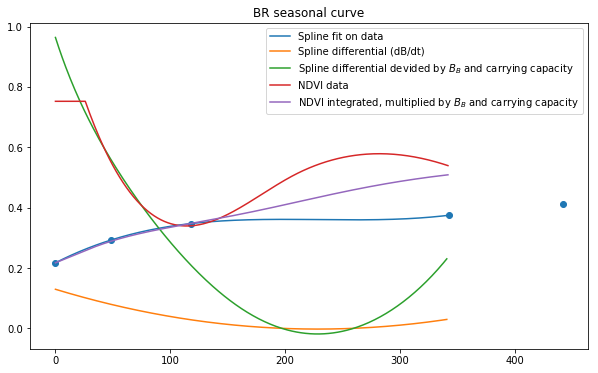

In [127]:
params, _ = data.get_params()
params['B_g'] /= 5 
# params['B_K'] *= .75

BR_data = []
for key in biom_data.keys():
    if key[-1] == 'B' and 'P' in key:
        BR_data.append(biom_data[key] / 9)
BR_cumulative = np.nanmean(np.vstack(BR_data), axis=0)
# BR_cumulative[-1] = BR_cumulative[-2]
# print(BR_cumulative[-1])

# Do a spline fit to data
dates = data.measurements
date_ax = [(date - dates[0]).days for date in dates]
BR_spline = inter.InterpolatedUnivariateSpline(date_ax[:-1], BR_cumulative[:-1])

days = range((dates[-2] - dates[0]).days)
cumm = BR_spline(days)
diff = np.diff(BR_spline(days)) / params['B_g']
seasonal_values = data.get_seasonality()
seasonal_ax = [seasonal_values[dates[0] + timedelta(i)] for i in days]
seasonal_ax = np.array(seasonal_ax)

seasonal_int = [BR_cumulative[0]]
for L_ext in seasonal_ax[:-1]:
    growth = L_ext * params['B_g'] * seasonal_int[-1] * (1 - seasonal_int[-1] / params['B_K'])
    seasonal_int.append(seasonal_int[-1] + growth)

plt.scatter(date_ax, BR_cumulative)
plt.plot(days, cumm, label="Spline fit on data")
plt.plot(days[:-1], diff, label="Spline differential (dB/dt)")
plt.plot(days[:-1], diff / (cumm[:-1] * (1 - cumm[:-1]/params['B_K'])), label="Spline differential devided by $B_B$ and carrying capacity")
plt.plot(days, seasonal_ax, label="NDVI data")
plt.plot(days, seasonal_int, label="NDVI integrated, multiplied by $B_B$ and carrying capacity")
plt.title("BR seasonal curve")
plt.legend()
plt.savefig('../results/BR_seasonal.png')
plt.show()

In [ ]:
# artificial = False
# prob_range = (.01, .04)
# N = 6
# probs = np.linspace(*prob_range, N)
#
# errors = []
# for value in probs:
# print("Running model for seed probability ",value)
# these_params, _ = data.get_params()
# these_params['seed_prob'] = value
#
# # Initiate and run models
# models = initiate_models(these_params)
# run_models(models)
#
# # Assign data to patches
# patches = data.assign_data(models, artificial)
#
# error = 0
# for patch in patches:
#     if len(patch.BR_original) != 0:
#         model_size = get_size(patch)
#         # TODO: Use also other diameters than the last one?
#         error += abs(model_size - patch.size[-1])
#
# errors.append(error)
#
#
# np.savetxt(fname, errors)